### EMTOOLS -- Validation
**Description:** This notebook is for qualitative and quantitative validation of automatically segmented images in the pipeline. It takes a validation image and a raw segmentation image as input, performs the same steps as the postprocessing step, and then validates the test image against the ground truth.

**Author:** Philip Ruthig, Paul Flechsig Institute, Center of Neuropathology and Brain Research Leipzig

**Contact:** philip.ruthig@medizin.uni-leipzig.de // philip.ruthig@gmail.com

**Publication:**
Please contact me if you want to use this code for any publication.

#### Correlations and errors quantified between predicted and validation (ground gruth) data:
- Area
- Eccentricity
- major axis length
- minor axis length
- g Ratio
- Percentage of False Positives / Negatives
- Bland-Altman plots of prediction and validation data
- IoU (Intersection over Union) Score (=Jaccard) 
- Dice Coefficient (=F1 Score)

In [145]:
# import dependencies
import numpy as np
import tifffile as tf
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os
import pandas as pd
import math as m
import skimage
import cv2
import scipy
from skimage.measure import regionprops, regionprops_table
from skimage.morphology import disk
import colorcet as cc
import IPython
%matplotlib inline

In [146]:
def resolve_undersegmentation(outer_labels,inner_labels):
    '''
    resolves undersegmented cells with 'kissing' cells. This function assumes that inner_labels never touch, but outer_labels do.
    Each corresponding outer area must touch each corresponding inner area.

    outer_labels = outer labels with undersegmented kissing cells that need to be seperated
    inner_labels = inner labels without undersegmented kissing cells

    returns: Two arrays of the same shape, with uniform labels across both images. 
    '''
    import numpy as np
    from skimage.segmentation import watershed
    from skimage.feature import peak_local_max
    outer_labels = outer_labels.astype('bool')
    inner_labels = inner_labels.astype('bool')
    # do distance transformation of combined binary image of outer+inner
    seg_dist = ndi.distance_transform_edt(outer_labels+inner_labels)
    # Generate the markers as local maxima of the distance to the background
    coords = peak_local_max(seg_dist, footprint=np.ones((3, 3)), labels=ndi.label(inner_labels)[0], num_peaks_per_label=1)
    # initializie empty mask 
    mask = np.zeros(seg_dist.shape, dtype=bool)
    # insert maximum points into the empty array
    mask[tuple(coords.T)] = True
    # label each maximum
    markers, n = ndi.label(mask)
    # perform watershed on outer_labels and inner_labels combined
    outer_cells = watershed(-seg_dist, markers, mask=(outer_labels+inner_labels))
    inner_cells = np.copy(outer_cells)
    # sort the cells (which are now labeled with the same label inner and outer) back into inner and outer labels
    inner_cells[inner_labels==0] = 0
    outer_cells[inner_labels==True] = 0
    return outer_cells,inner_cells

def keep_largest_structure(boolean_array):
    '''
    This function checks for structures of the same label and keeps only the biggest one.
    This is needed for cells that are double labeled so we can keep the largest one (which, we assume, is the real one).
    This function should only called for a mask of a single cell each time, as it assumes there is only one label in the input array.
    '''
    from scipy import ndimage
    # Label each connected component in the boolean array
    labeled_array, num_features = ndimage.label(boolean_array)

    # Calculate the size of each labeled component
    component_sizes = np.bincount(labeled_array.ravel())

    # Find the index of the largest component
    largest_component_index = np.argmax(component_sizes[1:]) + 1

    # Create a boolean mask to keep only the largest component
    largest_component_mask = labeled_array == largest_component_index

    # Apply the mask to the boolean array
    boolean_array[largest_component_mask] = True
    boolean_array[~largest_component_mask] = False

    return boolean_array

def calculate_iou(predicted_mask, ground_truth_mask):
    # IoU Score is equivalent to Jaccard
    # calculate intersection and union masks
    intersection = predicted_mask & ground_truth_mask # element-wise logical AND
    union = predicted_mask | ground_truth_mask #element-wise logical OR

    # calculate the number of pixels in the intersection and union masks
    n_intersection = intersection.sum()
    n_union = union.sum()

    # calculate the IoU score
    iou = n_intersection / n_union

    return iou

def calculate_dice(predicted_mask, ground_truth_mask):
    # This Dice coefficient is equivalent to F1 score.
    dice = np.sum(predicted_mask[ground_truth_mask==True]==True)*2.0 / (np.sum(predicted_mask[predicted_mask==True]==True) + np.sum(ground_truth_mask[ground_truth_mask==True]==True))
    return dice

# define qualitative colormap
glasbey = cc.cm.glasbey_dark_r
glasbey.set_under(color="black")

In [147]:
prediction_path =  r"4_val/prediction.png" #prediction file
validation_path = r"4_val/validation.png" #ground truth file
save_path = r"5_val_results/"

threshold_myelin = 50
threshold_fiber_upper = 40 
threshold_fiber_lower = 24

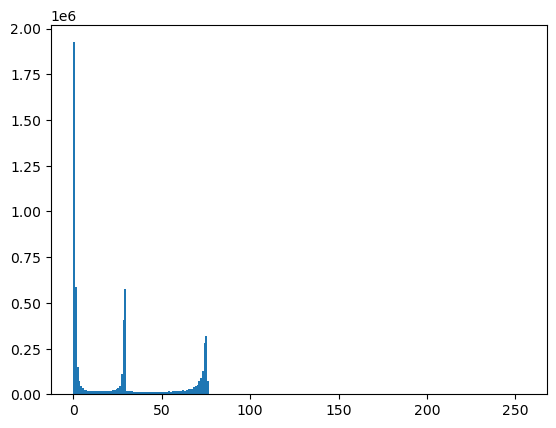

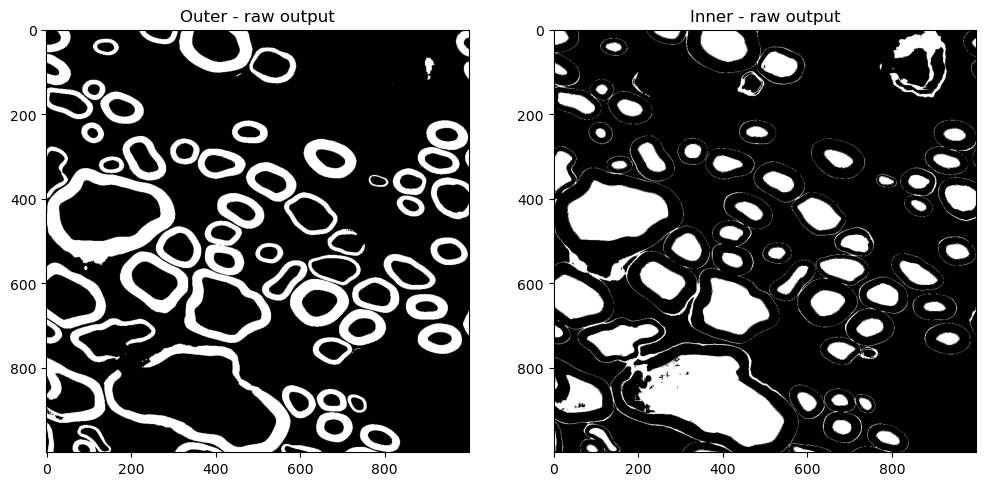

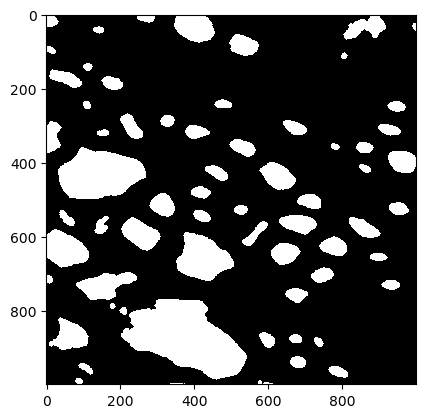

In [148]:
# open data
img = cv2.imread(prediction_path)
img_val = cv2.imread(validation_path)
val_inner = img_val[:,:,2]
val_outer = img_val[:,:,0]

# lose two dimensions, since its a grayscale img 
img = img[:,:,0]

# plot histogram of pixel intensities in the semantic segmentation
plt.hist(img.ravel(), bins=256, range=(0, 255),)
plt.show()

# split different labels
pred_outer = np.zeros_like(img) # myelin
pred_inner = np.zeros_like(img) # fibers

# Treshold the input image at given thresholds (defined in above cell)
pred_outer[img>threshold_myelin] = 1
pred_inner[img<threshold_fiber_upper] = 1
pred_inner[img<threshold_fiber_lower] = 0

# plot raw threshold
fig, axs = plt.subplots(ncols=2,figsize=(12,12))
axs[0].imshow(pred_outer[0:1000,0:1000], cmap='gray')
axs[1].imshow(pred_inner[0:1000,0:1000], cmap='gray')
axs[0].set_title('Outer - raw output')
axs[1].set_title('Inner - raw output')
plt.show()

# binary opening to get rid of small speckles
pred_inner = ndi.binary_opening(pred_inner,structure=disk(5))

# fill holes
pred_inner = ndi.binary_fill_holes(pred_inner)

# binary opening to get rid of small speckles (again)
pred_inner = ndi.binary_opening(pred_inner,structure=disk(7))

plt.imshow(pred_inner[0:1000,0:1000],interpolation='None',cmap='gray')
plt.show()

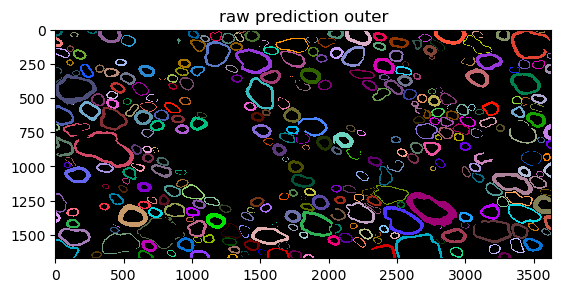

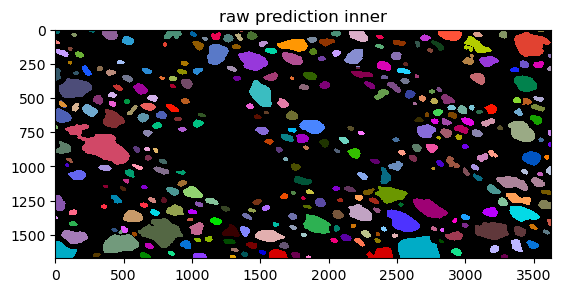

336


In [149]:
# fill inner to outer label to make sure they touch
pred_inner = ndi.binary_dilation(pred_inner,structure=disk(5))
pred_inner[pred_outer==True]=0

# binary opening to get rid of small speckles
pred_inner = ndi.binary_opening(pred_inner,structure=disk(2))

# fill holes
pred_inner = ndi.binary_fill_holes(pred_inner)

# binary opening to get rid of small speckles
pred_inner = ndi.binary_opening(pred_inner,structure=disk(6))

# dilate inner, then restrict it to everywhere where outer isnt true. Do this a few times.
# This is to make sure they are in contact and can be seperated by watershed later on
# Do not overdo it, or otherwise cells that are not completely enclosed by myelin will dilate a lot!
pred_inner = ndi.binary_dilation(pred_inner,structure=disk(3))
    # pred_inner[pred_outer==True]=False

#re-label so the labels are uniform between both channels.
pred_outer_labeled,pred_inner_labeled = resolve_undersegmentation(pred_outer.astype('bool'),pred_inner.astype('bool'))
plt.title('raw prediction outer')
plt.imshow(pred_outer_labeled,cmap=glasbey,interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
plt.show()

plt.title('raw prediction inner')
plt.imshow(pred_inner_labeled,cmap=glasbey,interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
plt.show()

n_pred_cells_raw = np.max(pred_inner_labeled)
print(n_pred_cells_raw)

In [150]:
print(len(np.unique(pred_outer_labeled)))
print(len(np.unique(pred_inner_labeled)))
print(np.unique(pred_outer_labeled))
print(np.unique(pred_inner_labeled))

330
337
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  30  31  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 186 187 188 189 190 191 192 193 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 24

In [151]:
n_labeled_without_outer = 0
n_labeled_without_inner = 0

# iterate through every structure in pred_inner, delete all cells that do not have axon or myelin.
for id in np.unique(pred_inner_labeled):
    # check if id is in pred_outer_labeled
    if id not in pred_outer_labeled:
        # if not, delete in pred_inner_labeled
        pred_inner_labeled[pred_inner_labeled==id] = 0
        print("deleted inner label #" + str(id))
        n_labeled_without_outer += 1

for id in np.unique(pred_outer_labeled):
    if id not in pred_inner_labeled:
        # if not, delete in pred_outer_labeled
        pred_outer_labeled[pred_outer_labeled==id] = 0
        print("deleted outer label #" + str(id))
        n_labeled_without_inner += 1

print (f"Number of cells without axon: {n_labeled_without_inner}")
print (f"Number of cells without myelin: {n_labeled_without_outer}")

deleted inner label #29
deleted inner label #32
deleted inner label #60
deleted inner label #185
deleted inner label #194
deleted inner label #285
deleted inner label #298
Number of cells without axon: 0
Number of cells without myelin: 7


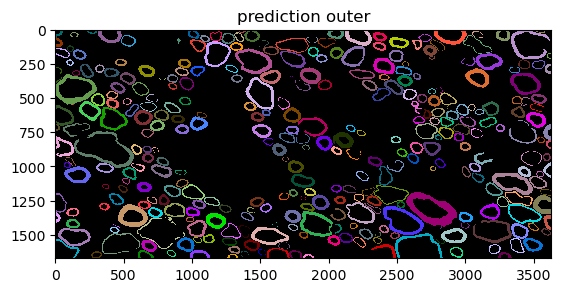

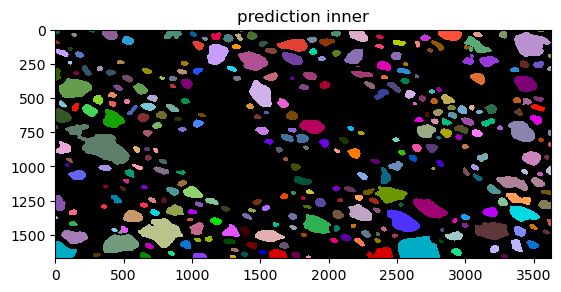

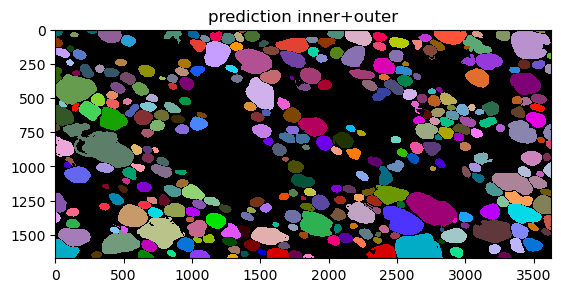

336


In [152]:
pred_outer_labeled,pred_inner_labeled = resolve_undersegmentation(pred_outer_labeled.astype('bool'),pred_inner_labeled.astype('bool'))
plt.title('prediction outer')
plt.imshow(pred_outer_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
plt.savefig(save_path + "\pre_prediction_outer.png",dpi=500)
plt.show()
plt.title('prediction inner')
plt.imshow(pred_inner_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
plt.savefig(save_path + "\pre_prediction_inner.png",dpi=500)
plt.show()
plt.title('prediction inner+outer')
plt.imshow(pred_inner_labeled+pred_outer_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
plt.savefig(save_path + "\pre_prediction_inner_outer.png",dpi=500)
plt.show()

n_pred_cells_corrected = np.max(pred_inner_labeled)
print(n_pred_cells_corrected)

In [153]:
print(len(np.unique(pred_outer_labeled)))
print(len(np.unique(pred_inner_labeled)))
print(np.unique(pred_outer_labeled))
print(np.unique(pred_inner_labeled))

332
337
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  62  63  64  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 24

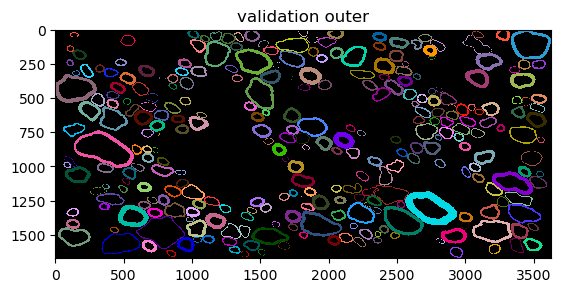

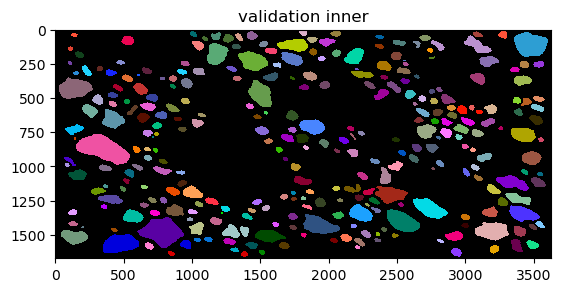

In [154]:
# fill inner to outer label to make sure they touch
# this is needed to ensure good watershed performance later
val_inner = ndi.binary_dilation(val_inner,structure=disk(5))
val_inner[val_outer==True]=0

#re-label so the labels are uniform between both channels.
val_outer_labeled,val_inner_labeled = resolve_undersegmentation(val_outer.astype('bool'),val_inner.astype('bool'))

plt.title('validation outer')
plt.imshow(val_outer_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
plt.show()
plt.title('validation inner')
plt.imshow(val_inner_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
plt.show()

In [155]:
# at this point, some of the cells do not have myelin. 
# Since we only look for myelinated cells, these are filtered out here.
idx_list = []
for idx in np.unique(pred_inner_labeled):
    if (pred_outer_labeled==idx).max() == False:
        pred_inner_labeled[pred_inner_labeled==idx] = 0
        idx_list.append(idx)
print('deleted cells because they don\'t have myelin: ' + str(idx_list))

deleted cells because they don't have myelin: [60, 61, 65, 298, 302]


In [156]:
pred_both_labeled = pred_inner_labeled+pred_outer_labeled
val_both_labeled = val_inner_labeled+val_outer_labeled

#### Cleanup of predicted data
Remove segmented cells that touch the border of the image.

In [157]:
n_cells_removed_border_pred = 0

# remove cells that intersect with the border
border_mask = np.zeros(pred_both_labeled.shape, dtype=bool)
border_mask = ndi.binary_dilation(border_mask,iterations=5, border_value=5)

for id in np.unique(pred_both_labeled):
    if id == 0:
        continue
    #keep only current cell as temporary mask
    current_id_mask = pred_both_labeled==id 

    # check if it overlaps with the border mask
    overlap = np.logical_and(border_mask,current_id_mask)
    overlap_n = np.sum(overlap)
    
    if overlap_n > 0:
        pred_both_labeled[pred_both_labeled==id] = 0
        print("deleted cell #" + str(id))
        n_cells_removed_border_pred += 1


deleted cell #1
deleted cell #2
deleted cell #3
deleted cell #4
deleted cell #5
deleted cell #6
deleted cell #7
deleted cell #8
deleted cell #9
deleted cell #10
deleted cell #12
deleted cell #14
deleted cell #25
deleted cell #28
deleted cell #41
deleted cell #44
deleted cell #63
deleted cell #74
deleted cell #96
deleted cell #132
deleted cell #151
deleted cell #160
deleted cell #174
deleted cell #179
deleted cell #188
deleted cell #205
deleted cell #231
deleted cell #247
deleted cell #250
deleted cell #271
deleted cell #273
deleted cell #294
deleted cell #323
deleted cell #326
deleted cell #327
deleted cell #328
deleted cell #329
deleted cell #330
deleted cell #331
deleted cell #332
deleted cell #333
deleted cell #334
deleted cell #335
deleted cell #336


In [158]:
n_cells_removed_border_val = 0

# remove cells that intersect with the border
border_mask = np.zeros(val_inner_labeled.shape, dtype=bool)
border_mask = ndi.binary_dilation(border_mask,iterations=5, border_value=5)

for id in np.unique(val_inner_labeled):
    if id == 0:
        continue
    #keep only current cell as temporary mask
    current_id_mask = val_both_labeled==id 

    # check if it overlaps with the border mask
    overlap = np.logical_and(border_mask,current_id_mask)
    overlap_n = np.sum(overlap)

    if overlap_n > 0:
        val_both_labeled[val_both_labeled==id] = 0
        print("deleted cell #" + str(id))
        n_cells_removed_border_val += 1


deleted cell #1
deleted cell #2
deleted cell #3
deleted cell #5
deleted cell #7
deleted cell #20
deleted cell #81
deleted cell #301


In [159]:
#### Post-Process filtering
# if there are multiple independent labels with the same labelling number,
# keep only the biggest one
for id in np.unique(pred_both_labeled):
    if id == 0:
        continue
    current_id_mask = pred_both_labeled==id 
    mask_labeled, n = ndi.label(current_id_mask)
    if n > 1:
        #delete all but the biggest one from this image and from pred_both_labeled
        current_id_kept = keep_largest_structure(current_id_mask)
        #correct the value of the boolean array to the current id
        current_id_kept = (current_id_kept*id).astype('uint16')
        #re-insert the remaining one to pred_both_labeled
        pred_both_labeled[pred_both_labeled==id] = 0
        pred_both_labeled = pred_both_labeled + current_id_kept        
        if plot_all == True:
            print ("Removed " + str(n-1) + " inner duplicates from id #" + str(id))

# if fibers are unreasonably small, remove them from further analysis.
for id in np.unique(pred_both_labeled):
    n_px = (np.count_nonzero(pred_both_labeled[pred_both_labeled==id]))
    if n_px < 5:
        pred_both_labeled[pred_both_labeled==id]=0
        print('deleted because smaller than 5 px: cell #' + str(id))

deleted because smaller than 5 px: cell #0


In [160]:
#seperate inner and outer channels from the combined pictures of predictions
pred_inner_labeled = np.copy(pred_both_labeled)
pred_inner_labeled[pred_inner==False]=0

pred_outer_labeled = np.copy(pred_both_labeled)
pred_outer_labeled[pred_outer==False]=0

# if fibers have a g ratio of >1, delete them from the predictions
table = regionprops_table(label_image=pred_inner_labeled,
                            properties=('label',
                                        'axis_minor_length',))
measurements_inner = pd.DataFrame(table)

table = regionprops_table(label_image=pred_outer_labeled,
                        properties=('label',
                                    'axis_minor_length',))
measurements_outer = pd.DataFrame(table)

#re-label columns so they are accurate
measurements_outer.columns = ['outer_' + col for col in measurements_outer.columns]
measurements_inner.columns = ['inner_' + col for col in measurements_inner.columns]

#put them in a single dataframe
measurements = pd.concat([measurements_inner,measurements_outer],axis=1)

px_size=5.23*4 # px size in nm

# correct all lengths and areas to the right size
factor_length = px_size / 1000 # 10^3 is from nm to µm
factor_area = px_size * px_size / 1000000 # 10^6 is from nm² to µm²
measurements['inner_axis_minor_length'] *= factor_length
measurements['outer_axis_minor_length'] *= factor_length

#add gratio to combined dataframe
measurements['gratio'] = measurements['inner_axis_minor_length']/measurements['outer_axis_minor_length']

# remove all cells with gratio >1 (since that is impossible)
index_gratio_greater_than_1 = list(measurements[measurements['gratio'] > 1].index)
index_gratio_greater_than_1 = [index + 1 for index in index_gratio_greater_than_1]
measurements = measurements[measurements['gratio'] <= 1]

# remove them from the combined image before continuing.
for id in np.unique(index_gratio_greater_than_1):
    pred_both_labeled[pred_both_labeled==id]=0

print(f'Cells with g ratio larger than 1: {index_gratio_greater_than_1}')

Cells with g ratio larger than 1: [19, 43, 96, 100, 240, 254, 255]


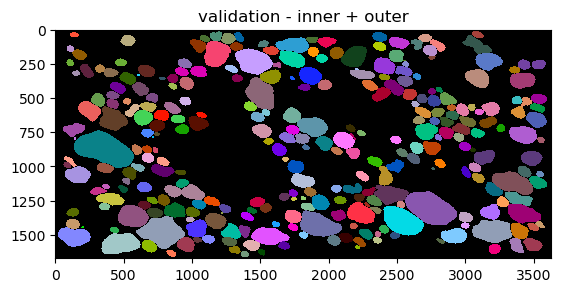

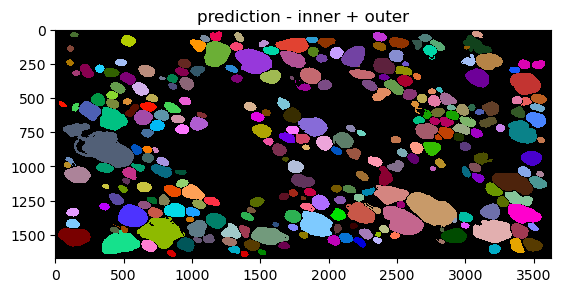

In [161]:
# "mislabeled" data. not congruent IDs for now
plt.title('validation - inner + outer')
plt.imshow(val_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1,vmax=np.max(pred_both_labeled))
plt.show()
plt.title('prediction - inner + outer')
plt.imshow(pred_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1,vmax=np.max(pred_both_labeled))
plt.show()

In [162]:
n_false_positive = 0
n_false_negative = 0

# Here, we start to define which cell (in predicted data) belongs to which other cell (in validation data). 
# Start by extracting centroids from the validation and prediction data.
# centroids_val = regionprops_table(label_image=val_inner_labeled,properties=('centroid',))
centroids_val = regionprops_table(label_image=val_both_labeled,properties=('centroid',))
centroids_val_x = centroids_val['centroid-0']
centroids_val_y = centroids_val['centroid-1']

# centroids_pred = regionprops_table(label_image=pred_inner_labeled,properties=('centroid',))
centroids_pred = regionprops_table(label_image=pred_both_labeled,properties=('centroid',))
centroids_pred_x = centroids_pred['centroid-0']
centroids_pred_y = centroids_pred['centroid-1']

# stack arrays to 2-dimensional arrays
val_points = np.column_stack((centroids_val_x, centroids_val_y))
pred_points = np.column_stack((centroids_pred_x, centroids_pred_y))

# initialize boolean array which has True values where centroids are for both sets of cells
val_bool_array = np.zeros_like(pred_both_labeled, dtype=bool)
for yx in val_points:
    val_bool_array[round(yx[0]),round(yx[1])]=True

pred_bool_array = np.zeros_like(pred_both_labeled, dtype=bool)
for yx in pred_points:
    pred_bool_array[round(yx[0]),round(yx[1])]=True

# label centroid bool arrays by iterating through them
bool_array_val_labeled,n = ndi.label(val_bool_array)
bool_array_pred_labeled,n_pred = ndi.label(pred_bool_array)

# iterate through validation cells, delete ones that do not have a matching predicted cell
for id in np.unique(bool_array_val_labeled):
    if id == 0:
        continue
    y,x = np.argwhere(bool_array_val_labeled==id)[0]
    # if this statement is true, the cell has not been found. 
    # therefore, we exclude it from further validation and flood fill it with 0's in validation data.
    if pred_both_labeled[y,x] == 0:
        val_both_labeled = skimage.segmentation.flood_fill(val_both_labeled,
                                                          (y,x),
                                                          new_value=0,
                                                          )
        print('deleted cell in validation data (found a false negative): ' + str(id))
        n_false_negative += 1

# iterate through predicted cells, delete ones that do not have a matching predicted cell
for id in np.unique(bool_array_pred_labeled):
    if id == 0:
        continue
    y,x = np.argwhere(bool_array_pred_labeled==id)[0]
    
    if val_both_labeled[y,x]==0:# if there is no cell to test against, delete cell
        pred_both_labeled = skimage.segmentation.flood_fill(image=pred_both_labeled,
                                                       seed_point=(y,x),
                                                       new_value=0,
                                                       )
        print('deleted cell in prediction data (found a false positive): ' + str(id))
        n_false_positive +=1


deleted cell in validation data (found a false negative): 7
deleted cell in validation data (found a false negative): 27
deleted cell in validation data (found a false negative): 30
deleted cell in validation data (found a false negative): 33
deleted cell in validation data (found a false negative): 42
deleted cell in validation data (found a false negative): 56
deleted cell in validation data (found a false negative): 79
deleted cell in validation data (found a false negative): 106
deleted cell in validation data (found a false negative): 139
deleted cell in validation data (found a false negative): 141
deleted cell in validation data (found a false negative): 142
deleted cell in validation data (found a false negative): 146
deleted cell in validation data (found a false negative): 161
deleted cell in validation data (found a false negative): 203
deleted cell in validation data (found a false negative): 213
deleted cell in validation data (found a false negative): 219
deleted cell in 

In [163]:
# val_both_labeled_temp, n = ndi.label(val_both_labeled)
# pred_both_labeled_temp, n2 = ndi.label(pred_both_labeled)
# # at this point, both arrays should have the same number of cells:
# print('cells in validation data: ' + str(n))
# print('cells in predicted data: ' + str(n2))

In [164]:
# Now, we need to label each specific cell with the same label in prediction and validation arrays.
# To do that, we iterate through the prediction array and label the validation cells with the same number.
# We do this by flood filling from each centroid.
for id in np.unique(bool_array_val_labeled):
    if id == 0:
        continue
    y,x = np.argwhere(bool_array_val_labeled==id)[0]

    # if there is no cell at the point want to fill it in, delete cell altogether
    if pred_both_labeled[y,x]==0: # if this is true: delete cell
        val_both_labeled = skimage.segmentation.flood_fill(image=val_both_labeled,
                                                           seed_point=(y,x),
                                                           new_value=0,
                                                          )
        print("cell deleted: " + str(id) + str(" - found false negative"))
        n_false_negative += 1
        continue

    # if there is a cell, fill it in with the same label as in mask_val_labeled
    pred_both_labeled = skimage.segmentation.flood_fill(image=pred_both_labeled,
                                                   seed_point=(y,x),
                                                   new_value=id,
                                                   )
    
    # if there is a cell, fill it in with the same label as in mask_val_labeled
    val_both_labeled = skimage.segmentation.flood_fill(image=val_both_labeled,
                                                   seed_point=(y,x),
                                                   new_value=id,
                                                   )



cell deleted: 7 - found false negative
cell deleted: 27 - found false negative
cell deleted: 30 - found false negative
cell deleted: 33 - found false negative
cell deleted: 42 - found false negative
cell deleted: 56 - found false negative
cell deleted: 79 - found false negative
cell deleted: 106 - found false negative
cell deleted: 139 - found false negative
cell deleted: 141 - found false negative
cell deleted: 142 - found false negative
cell deleted: 146 - found false negative
cell deleted: 161 - found false negative
cell deleted: 203 - found false negative
cell deleted: 213 - found false negative
cell deleted: 219 - found false negative
cell deleted: 226 - found false negative
cell deleted: 230 - found false negative
cell deleted: 232 - found false negative
cell deleted: 240 - found false negative
cell deleted: 253 - found false negative
cell deleted: 259 - found false negative
cell deleted: 290 - found false negative


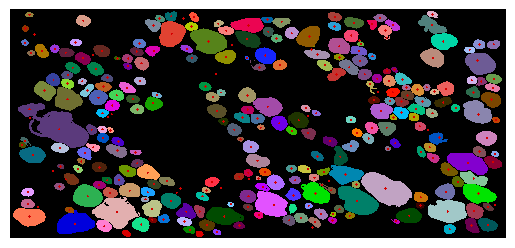

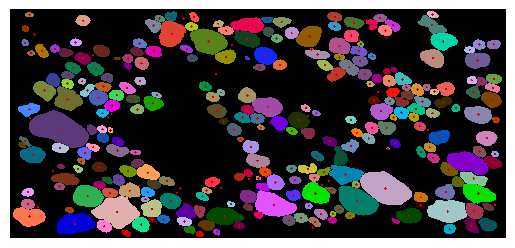

In [165]:
bool_array_labeled_dil = ndi.binary_dilation(bool_array_val_labeled,iterations=10)

plt.axis("off")
plt.imshow(pred_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
plt.imshow(np.ma.array(bool_array_labeled_dil, mask=bool_array_labeled_dil==0), interpolation='none', cmap=glasbey,vmin=0.1)
plt.show()

plt.axis("off")
plt.imshow(val_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1)
plt.imshow(np.ma.array(bool_array_labeled_dil, mask=bool_array_labeled_dil==0), interpolation='none', cmap=glasbey,vmin=0.1)
plt.show()

# plt.imshow(ndi.binary_dilation(bool_array_labeled,iterations=10))
# plt.show()

In [166]:
print(len(np.unique(val_both_labeled)))
print(len(np.unique(pred_both_labeled)))

273
271


In [167]:
#seperate inner and outer channels back from the combined pictures
pred_inner_labeled = np.copy(pred_both_labeled)
pred_inner_labeled[pred_inner==False]=0

pred_outer_labeled = np.copy(pred_both_labeled)
pred_outer_labeled[pred_outer==False]=0

val_inner_labeled = np.copy(val_both_labeled)
val_inner_labeled[val_inner==False] = 0

val_outer_labeled = np.copy(val_both_labeled)
val_outer_labeled[val_outer==False] = 0

In [168]:
print(len(np.unique(pred_outer_labeled)))
print(len(np.unique(pred_inner_labeled)))
print(len(np.unique(val_outer_labeled)))
print(len(np.unique(val_inner_labeled)))

271
271
272
273


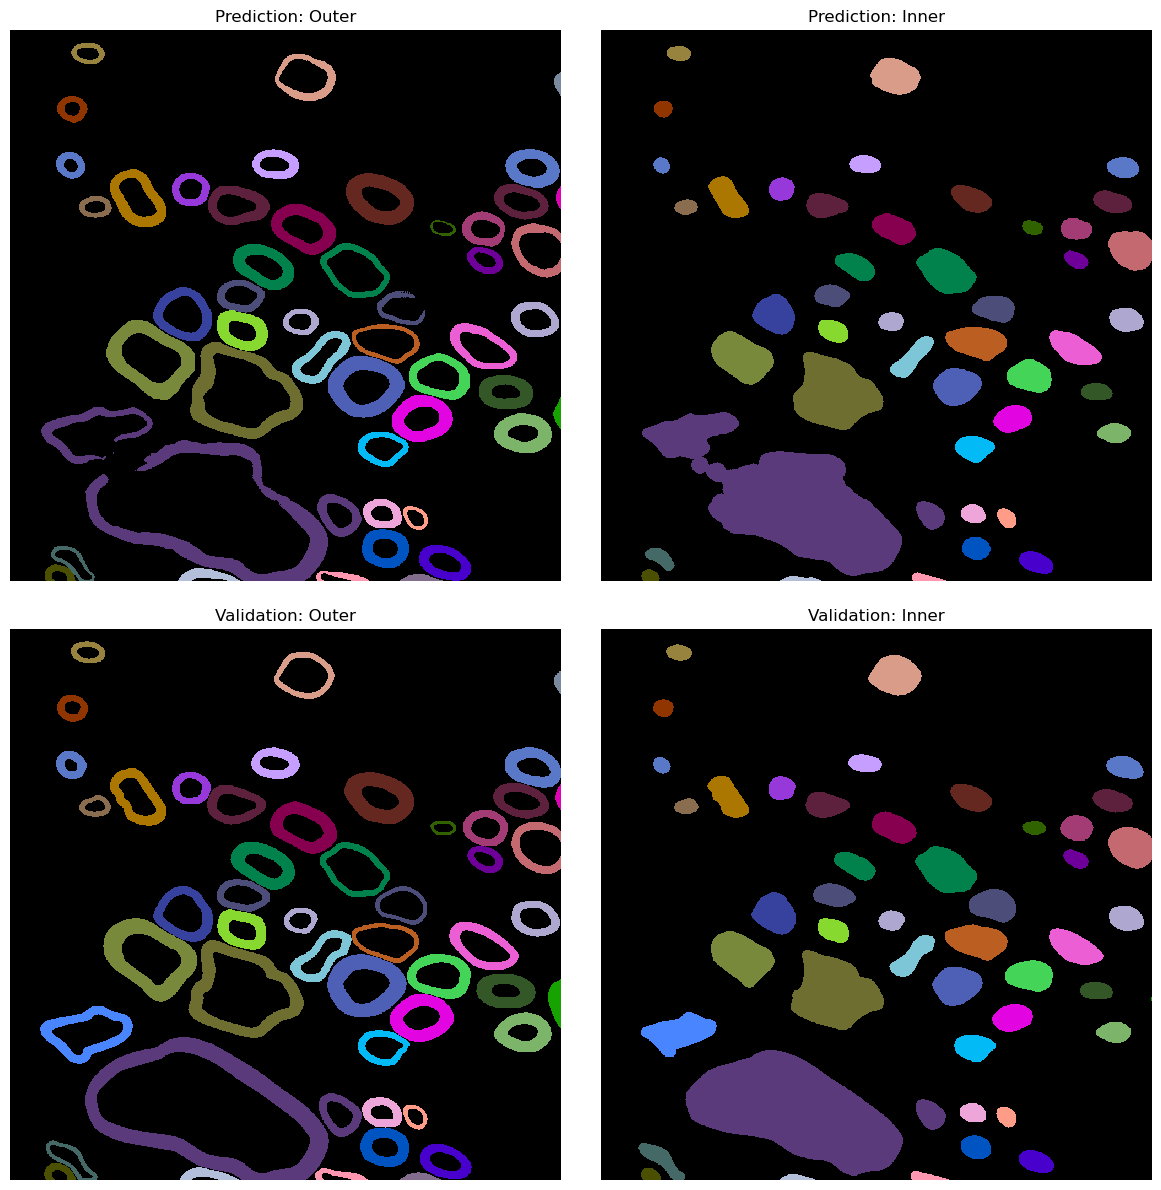

In [169]:
#plot all four channels in 2x2 grid
fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(12,12))
axs[0,0].imshow(pred_outer_labeled[0:1000,0:1000], cmap=glasbey, interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
axs[0,1].imshow(pred_inner_labeled[0:1000,0:1000], cmap=glasbey, interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
axs[1,0].imshow(val_outer_labeled[0:1000,0:1000], cmap=glasbey, interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
axs[1,1].imshow(val_inner_labeled[0:1000,0:1000], cmap=glasbey, interpolation='None',vmin=0.1,vmax=pred_outer_labeled.max())
# Remove axis for each subplot
axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')
axs[0,0].set_title('Prediction: Outer')
axs[0,1].set_title('Prediction: Inner')
axs[1,0].set_title('Validation: Outer')
axs[1,1].set_title('Validation: Inner')
plt.tight_layout(h_pad=2)
plt.savefig(save_path + "\predict_val_comparison.png",dpi=500)
plt.show()

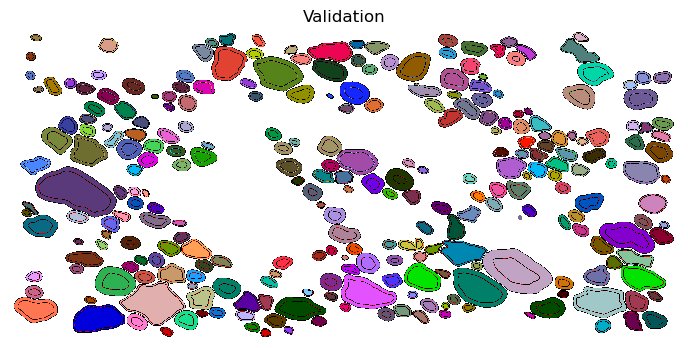

In [170]:
# plot overlay of inner + outer
# generate 2px outline of inner and outer area
val_outer_eroded = ndi.binary_erosion(val_outer_labeled,structure=disk(3))
ero = np.logical_xor(val_outer_labeled.astype('bool'),val_outer_eroded)

plt.figure(figsize=(12,4))
plt.title('Validation')
plt.imshow(np.ma.array(val_inner_labeled + val_outer_labeled, mask=(val_inner_labeled + val_outer_labeled) == 0), cmap=glasbey,interpolation='none',vmin=0.1,vmax=pred_outer_labeled.max())
plt.imshow(np.ma.array(ero, mask=(ero) == 0), interpolation='None', cmap='gray',)
plt.axis('off')
plt.savefig(save_path + "val_labeled_cells_outlined.png",dpi=500)
plt.show()

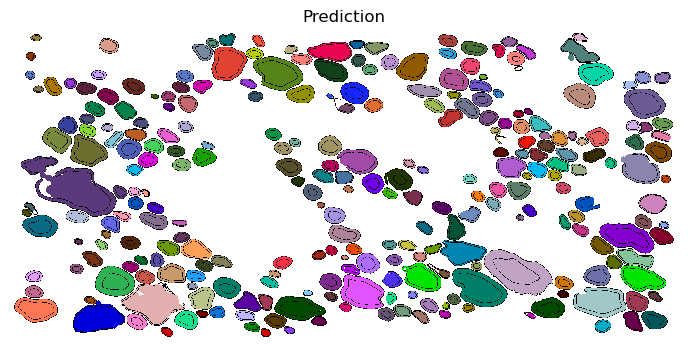

In [171]:
# plot overlay of inner + outer
# generate 2px outline of inner and outer area
pred_outer_eroded = ndi.binary_erosion(pred_outer_labeled,structure=disk(3))
ero = np.logical_xor(pred_outer_labeled.astype('bool'),pred_outer_eroded)

plt.figure(figsize=(12,4))
plt.title('Prediction')
plt.imshow(np.ma.array(pred_inner_labeled + pred_outer_labeled, mask=(pred_inner_labeled + pred_outer_labeled) == 0), cmap=glasbey,interpolation='none',vmin=0.1,vmax=pred_outer_labeled.max())
plt.imshow(np.ma.array(ero, mask=(ero) == 0), interpolation='None', cmap='gray',)
plt.axis('off')
plt.savefig(save_path + "pred_labeled_cells_outlined.png",dpi=500)
plt.show()

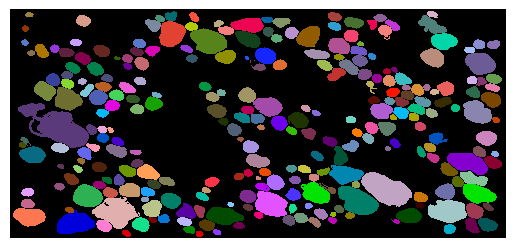

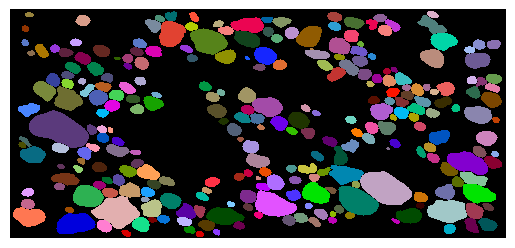

In [172]:
plt.axis("off")
plt.imshow(pred_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1,vmax=np.max(pred_both_labeled))
# plt.imshow(np.ma.array(bool_array_val_labeled, mask=bool_array_val_labeled==0), interpolation='none', cmap='tab20')
plt.show()

plt.axis("off")
plt.imshow(val_both_labeled,cmap=glasbey,interpolation='None',vmin=0.1,vmax=np.max(pred_both_labeled))
# plt.imshow(np.ma.array(bool_array_val_labeled, mask=bool_array_val_labeled==0), interpolation='none', cmap='tab20')
plt.show()

In [173]:
# here, we hard filter every cell that does not have a corresponding val or pred cell. Mostly, these are single pixel cells

# iterate through np.unique(pred_outer_labeled), delete all cells that do not have corresponding inner or outer
# also delete every cell that does not have a corresponding val or pred cell
for id in np.unique(pred_outer_labeled):
    # check if id is in val_outer_labeled
    if id not in val_outer_labeled:
        # if not, delete in pred_outer_labeled
        pred_outer_labeled[pred_outer_labeled==id] = 0
        print("deleted outer prediction label #" + str(id))
        n_false_positive += 1

for id in np.unique(val_outer_labeled):
    if id not in pred_outer_labeled:
        # if not, delete in pred_outer_labeled
        val_outer_labeled[val_outer_labeled==id] = 0
        print("deleted outer validation label #" + str(id))
        n_false_negative += 1

for id in np.unique(pred_inner_labeled):
    if id not in val_inner_labeled:
        # if not, delete in pred_outer_labeled
        pred_inner_labeled[pred_inner_labeled==id] = 0
        print("deleted inner prediction label #" + str(id))
        n_false_positive += 1


for id in np.unique(val_inner_labeled):
    if id not in pred_inner_labeled:
        # if not, delete in pred_outer_labeled
        val_inner_labeled[val_inner_labeled==id] = 0
        print("deleted inner validation label #" + str(id))
        n_false_negative += 1


deleted outer prediction label #181
deleted outer validation label #46
deleted outer validation label #130
deleted inner validation label #46
deleted inner validation label #130


In [174]:
# iterate through np.unique(pred_inner_labeled), delete all cells that do not have axon or myelin.
for id in np.unique(pred_inner_labeled):
    # check if id is in pred_outer_labeled
    if id not in pred_outer_labeled:
        # if not, delete in pred_inner_labeled
        pred_inner_labeled[pred_inner_labeled==id] = 0
        val_inner_labeled[val_inner_labeled==id] = 0
        print("deleted inner label #" + str(id))
        n_labeled_without_outer += 1

for id in np.unique(pred_outer_labeled):
    if id not in pred_inner_labeled:
        # if not, delete in pred_outer_labeled
        pred_outer_labeled[pred_outer_labeled==id] = 0
        val_outer_labeled[val_outer_labeled==id] = 0
        print("deleted outer label #" + str(id))
        n_labeled_without_inner += 1

deleted inner label #181


In [175]:
# if there are multiple independent labels with the same labelling number, keep only the biggest one - Inner
for id in np.unique(pred_inner_labeled):
    if id == 0:
        continue
    current_id_mask = pred_inner_labeled==id 
    mask_labeled, n = ndi.label(current_id_mask)
    if n > 1:
        #delete all but the biggest one from this image and from pred_inner_labeled
        current_id_kept = keep_largest_structure(current_id_mask)
        #correct the value of the boolean array to the current id
        current_id_kept = (current_id_kept*id).astype('uint16')
        #re-insert the remaining one to pred_inner_labeled
        pred_inner_labeled[pred_inner_labeled==id] = 0
        pred_inner_labeled = pred_inner_labeled + current_id_kept        
        print ("Removed " + str(n-1) + " duplicates from id #" + str(id))


Removed 3 duplicates from id #17
Removed 1 duplicates from id #29
Removed 2 duplicates from id #55
Removed 1 duplicates from id #59
Removed 1 duplicates from id #231
Removed 1 duplicates from id #262
Removed 1 duplicates from id #272
Removed 4 duplicates from id #283
Removed 1 duplicates from id #284


In [176]:
# if there are multiple independent labels with the same labelling number, keep only the biggest one - Outer
for id in np.unique(pred_outer_labeled):
    if id == 0:
        continue
    current_id_mask = pred_outer_labeled==id 
    mask_labeled, n = ndi.label(current_id_mask)
    if n > 1:
        #delete all but the biggest one from this image and from pred_inner_labeled
        current_id_kept = keep_largest_structure(current_id_mask)
        #correct the value of the boolean array to the current id
        current_id_kept = (current_id_kept*id).astype('uint16')
        #re-insert the remaining one to pred_inner_labeled
        pred_outer_labeled[pred_outer_labeled==id] = 0
        pred_outer_labeled = pred_outer_labeled + current_id_kept        
        print ("Removed " + str(n-1) + " duplicates from id #" + str(id))


Removed 5 duplicates from id #13
Removed 1 duplicates from id #14
Removed 1 duplicates from id #59
Removed 1 duplicates from id #121
Removed 2 duplicates from id #126
Removed 3 duplicates from id #140
Removed 5 duplicates from id #158
Removed 2 duplicates from id #263
Removed 7 duplicates from id #266
Removed 1 duplicates from id #283
Removed 1 duplicates from id #284


In [177]:
print(len(np.unique(pred_outer_labeled)))
print(len(np.unique(pred_inner_labeled)))
print(len(np.unique(val_outer_labeled)))
print(len(np.unique(val_inner_labeled)))

270
270
270
270


In [178]:
# print(np.unique(pred_inner_labeled) not in np.unique(val_inner_labeled))
# for id in np.unique(pred_inner_labeled):
#     if id in val_outer_labeled:
#         continue
#     print(str(id))
# np.argwhere(pred_inner_labeled==181)

In [179]:
tf.imwrite(save_path + "/pred_inner_labeled.tif",pred_inner_labeled)
tf.imwrite(save_path + "/pred_outer_labeled.tif",pred_outer_labeled)
tf.imwrite(save_path + "/val_inner_labeled.tif",val_inner_labeled)
tf.imwrite(save_path + "/val_outer_labeled.tif",val_outer_labeled)
tf.imwrite(save_path + "/bool_array_labeled.tif",bool_array_labeled_dil)

In [180]:
### calculate IoU scores
iou_inner = calculate_iou(pred_inner_labeled.astype('bool'),val_inner_labeled.astype('bool'))
iou_outer = calculate_iou(pred_outer_labeled.astype('bool'),val_outer_labeled.astype('bool'))
### calculate Dice Coefficients / F1 score
dice_inner = calculate_dice(pred_inner_labeled.astype('bool'),val_inner_labeled.astype('bool'))
dice_outer = calculate_dice(pred_outer_labeled.astype('bool'),val_outer_labeled.astype('bool'))

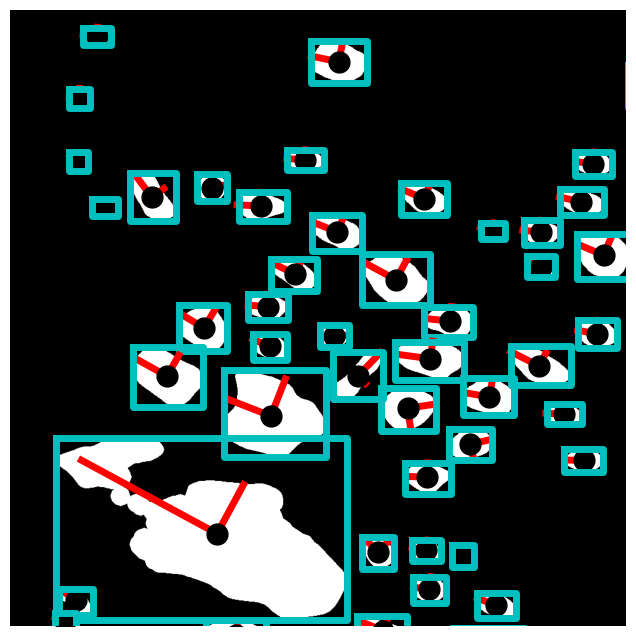

In [181]:
# plot centroids, measurements, major and minor axis on image to sanity check
regions = regionprops(pred_inner_labeled)

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(pred_inner_labeled.astype('bool'), cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + m.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - m.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - m.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - m.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=5)
    ax.plot(x0, y0, '.k', markersize=30)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-c', linewidth=5)

ax.set_axis_off()
ax.axis((0, 1000, 1000, 0))
plt.savefig(save_path + "\inner_clocks.png",dpi=500)
plt.show()

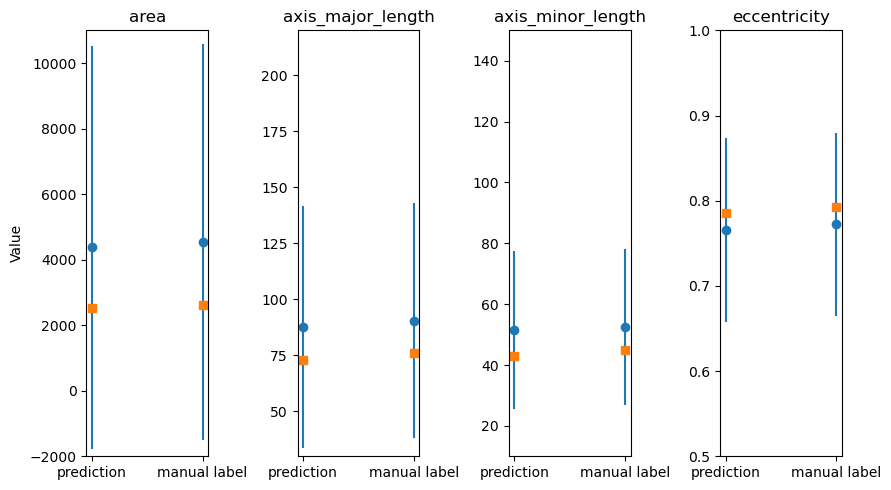

In [182]:
## now that we have the same amount of cells and all cells have the same label in both pictures, we extract measurements for validation
table_inner_pred = regionprops_table(label_image=pred_inner_labeled,
                          properties=('label',
                                      'area',
                                      'centroid',
                                      'axis_major_length',
                                      'axis_minor_length',
                                      'eccentricity',
                                      'extent',
                                      'equivalent_diameter_area',
                                      'orientation',
                                      'slice',))
measurements_inner_pred = pd.DataFrame(table_inner_pred)
#measurements_inner_pred.drop(index=66,inplace=True)

table_inner_val = regionprops_table(label_image=val_inner_labeled,
                              properties=('label',
                                          'area',
                                          'centroid',
                                          'axis_major_length',
                                          'axis_minor_length',
                                          'eccentricity',
                                          'extent',
                                          'equivalent_diameter_area',
                                          'orientation',
                                          'slice',))
measurements_inner_val = pd.DataFrame(table_inner_val)
#measurements_inner_val.drop(index=66,inplace=True)

# drop uninteresting columns for now
measurements_inner_val=measurements_inner_val.drop(columns=['label','centroid-0','centroid-1','extent','equivalent_diameter_area','orientation','slice'])
measurements_inner_pred=measurements_inner_pred.drop(columns=['label','centroid-0','centroid-1','extent','equivalent_diameter_area','orientation','slice'])

# calculate mean and std of all columns for both dataframes
stats_inner_pred = pd.concat([measurements_inner_pred.mean(),measurements_inner_pred.median(), measurements_inner_pred.std()], axis=1)
stats_inner_pred.columns = ['mean','median', 'std']
stats_inner_pred['dataset'] = 'prediction'

stats_inner_val = pd.concat([measurements_inner_val.mean(),measurements_inner_val.median(), measurements_inner_val.std()], axis=1)
stats_inner_val.columns = ['mean','median', 'std']
stats_inner_val['dataset'] = 'manual label'

# combine the two datasets
stats = pd.concat([stats_inner_pred, stats_inner_val])

# plot the data as a box plot
fig, axs = plt.subplots(ncols=measurements_inner_pred.shape[1], figsize=(9, 5),)

for i, col in enumerate(measurements_inner_pred.columns):
    ax = axs[i]
    col_stats = stats.loc[stats.index == col, :]
    xticks = np.arange(len(col_stats))
    ax.errorbar(xticks, col_stats['mean'], yerr=col_stats['std'], fmt='o', label='Mean')
    ax.errorbar(xticks, col_stats['median'], fmt='s', label='Median')
    ax.set_xticks(xticks)
    ax.set_xticklabels(col_stats['dataset'])
    ax.set_title(col)
    if i == 0:
        ax.set_ylabel('Value')
        ax.set_ylim(-2000,11000)
    if i == 1:
        ax.set_ylim(30,220)
    if i == 2:
        ax.set_ylim(10,150)
    if i == 3:
        ax.set_ylim(0.5,1)
    
plt.tight_layout()
plt.savefig(save_path + "\inner_lineplot.png",dpi=500)
plt.show()

In [183]:
print('predicted stats:')
print(stats_inner_pred)
print('')
print('validation stats:')
print(stats_inner_val)

predicted stats:
                          mean       median          std     dataset
area               4372.457249  2513.000000  6164.233591  prediction
axis_major_length    87.574671    72.982539    53.982635  prediction
axis_minor_length    51.513144    42.926820    26.111402  prediction
eccentricity          0.765504     0.785428     0.107929  prediction

validation stats:
                          mean       median          std       dataset
area               4537.423792  2625.000000  6040.534835  manual label
axis_major_length    90.521470    76.280509    52.393996  manual label
axis_minor_length    52.556675    45.060825    25.608953  manual label
eccentricity          0.772364     0.792323     0.107237  manual label


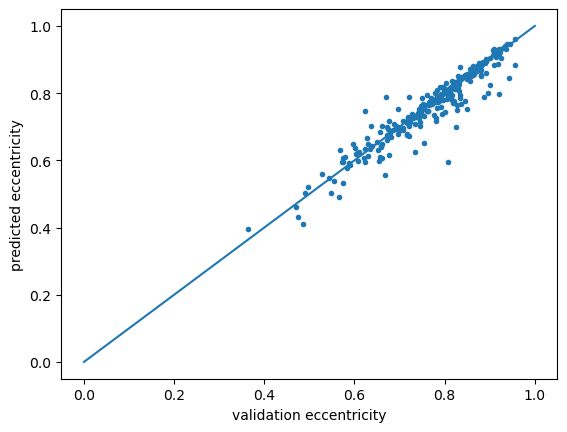

LinregressResult(slope=0.9537474880237332, intercept=0.028864546983308537, rvalue=0.9476383101328545, pvalue=2.2342616778771157e-134, stderr=0.019669628076967028, intercept_stderr=0.015337298279712152)


In [184]:
x = np.arange(0,2)
y = np.arange(0,2)
set_val = (measurements_inner_val['eccentricity'])
set_pred = (measurements_inner_pred['eccentricity'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation eccentricity')
plt.ylabel('predicted eccentricity')
plt.savefig(save_path + "\inner_ecc.png",dpi=500)
plt.show()
print(stats_val_pred)

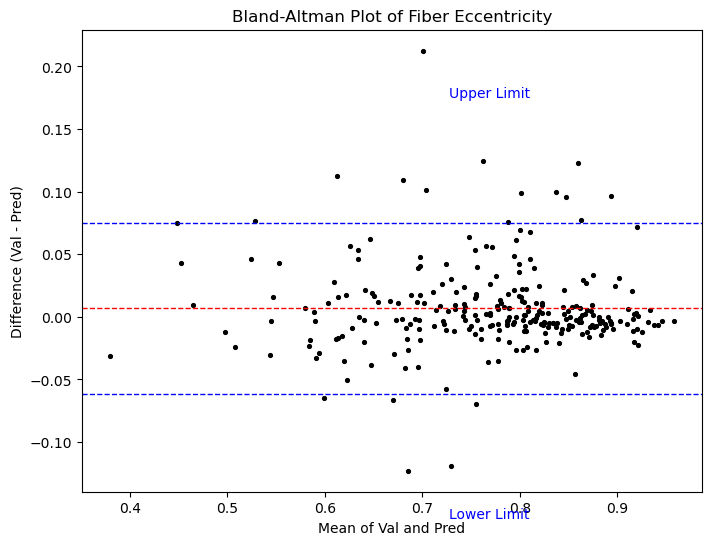

In [185]:
# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Fiber Eccentricity')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\inner_ecc_ba.png",dpi=500)

# Display the plot
plt.show()


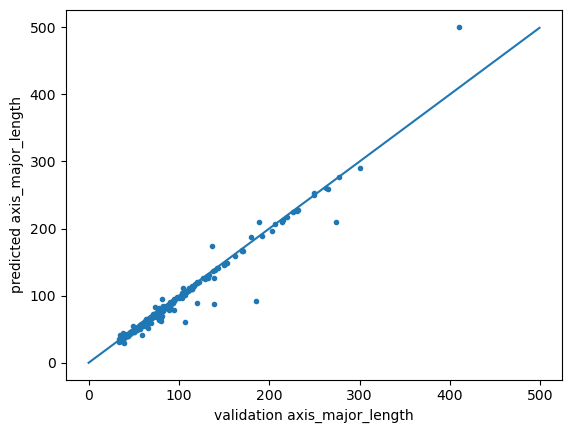

LinregressResult(slope=1.0098189528848434, intercept=-3.835625221546323, rvalue=0.9801012828370089, pvalue=1.5770928990564131e-189, stderr=0.012516219513011913, intercept_stderr=1.3084725749860022)


In [186]:
x = np.arange(0,500)
y = np.arange(0,500)
set_val = (measurements_inner_val['axis_major_length'])
set_pred = (measurements_inner_pred['axis_major_length'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation axis_major_length')
plt.ylabel('predicted axis_major_length')
#plt.ylim(-20,520)
#plt.xlim(-20,520)
plt.savefig(save_path + "\inner_major.png",dpi=500)
plt.show()
print(stats_val_pred)

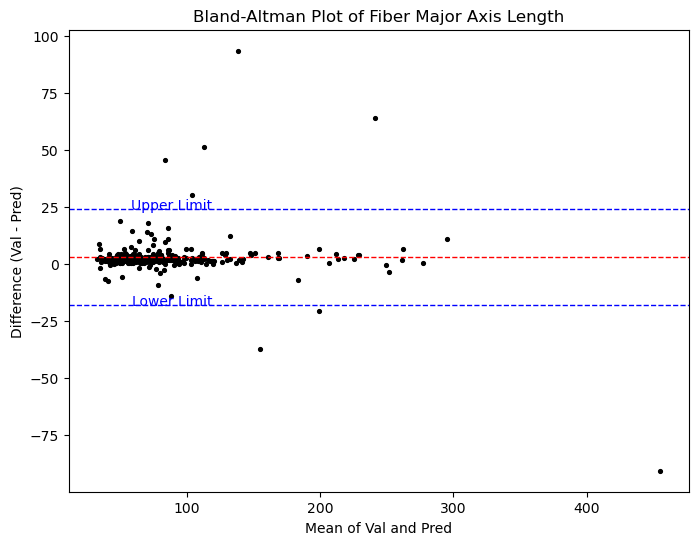

In [187]:
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30,marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Fiber Major Axis Length')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Display the plot
plt.show()


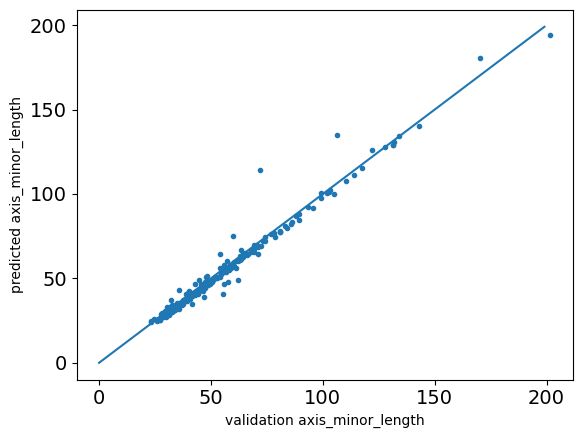

LinregressResult(slope=1.0065712192666423, intercept=-1.3888920143321357, rvalue=0.9872022712224765, pvalue=6.477224105635784e-215, stderr=0.009951080061587634, intercept_stderr=0.5815709992865586)


In [188]:
x = np.arange(0,200)
y = np.arange(0,200)
set_val = (measurements_inner_val['axis_minor_length'])
set_pred = (measurements_inner_pred['axis_minor_length'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

plt.xticks([0, 50, 100, 150, 200])
plt.yticks([0, 50, 100, 150, 200])

plt.tick_params(axis='both', which='major', labelsize=14)  # You can adjust the font size as needed

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation axis_minor_length')
plt.ylabel('predicted axis_minor_length')
plt.savefig(save_path + "\inner_minor.png",dpi=500)
plt.show()
print(stats_val_pred)

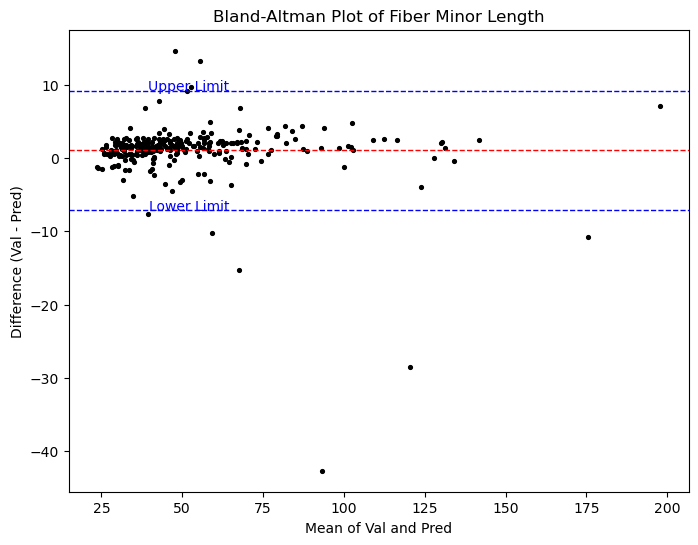

In [189]:
# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Fiber Minor Length')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\inner_minor_ba.png",dpi=500)

# Display the plot
plt.show()


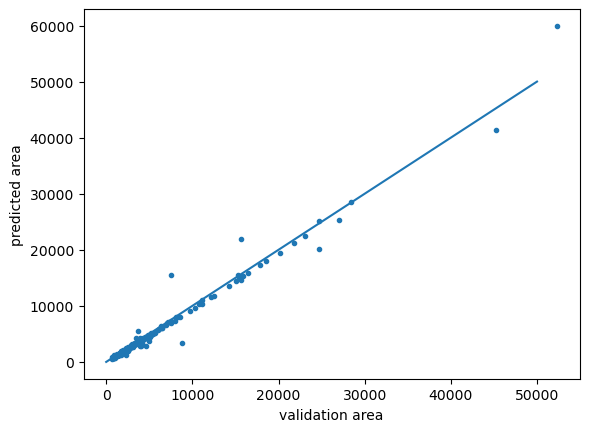

LinregressResult(slope=1.0079819185604673, intercept=-201.18388993157532, rvalue=0.9877545686560865, pvalue=1.8601916180905708e-217, stderr=0.009743533617690052, intercept_stderr=73.52374685044325)


In [190]:
x = np.arange(0,50000)
y = np.arange(0,50000)
set_val = (measurements_inner_val['area'])
set_pred = (measurements_inner_pred['area'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation area')
plt.ylabel('predicted area')
plt.savefig(save_path + "\inner_area.png",dpi=500)
plt.show()
print(stats_val_pred)

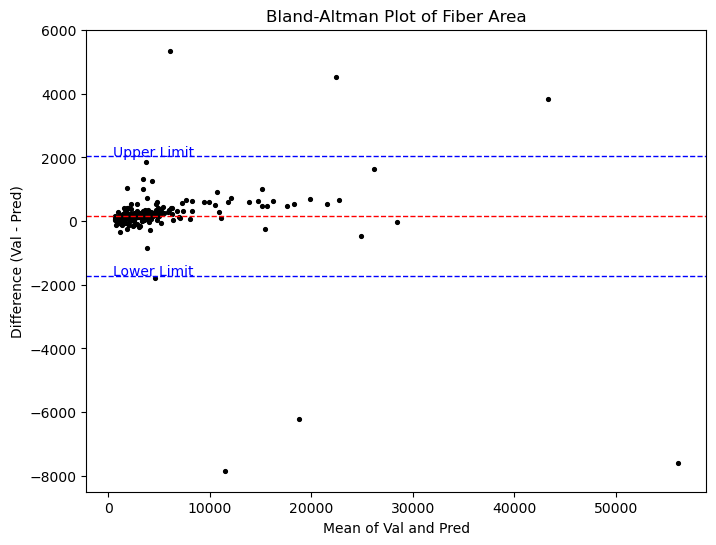

In [191]:
# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Fiber Area')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\inner_area_ba.png",dpi=500)

# Display the plot
plt.show()


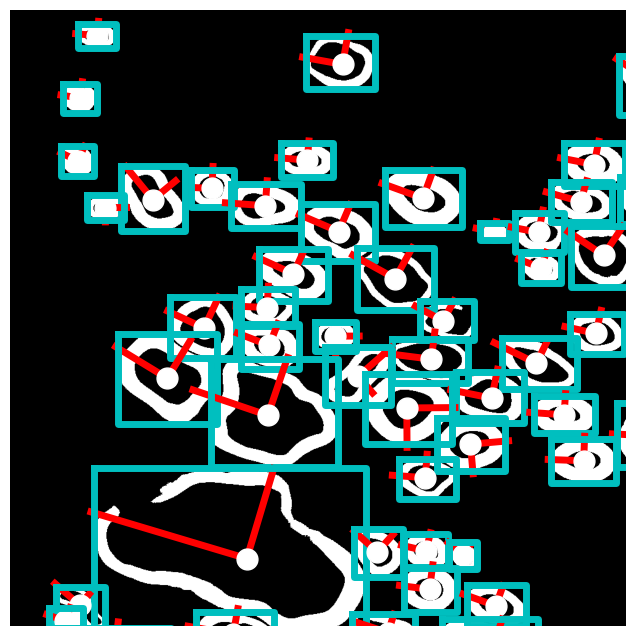

In [192]:
##### now do the same as above for the outer channel
# plot centroids, measurements, major and minor axis on image to sanity check
regions = regionprops(pred_outer_labeled)

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(pred_outer_labeled.astype('bool'), cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + m.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - m.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - m.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - m.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=5)
    ax.plot(x0, y0, '.w', markersize=30)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-c', linewidth=5)

ax.set_axis_off()
ax.axis((0, 1000, 1000, 0))
plt.savefig(save_path + "\outer_clocks.png",dpi=500)
plt.show()

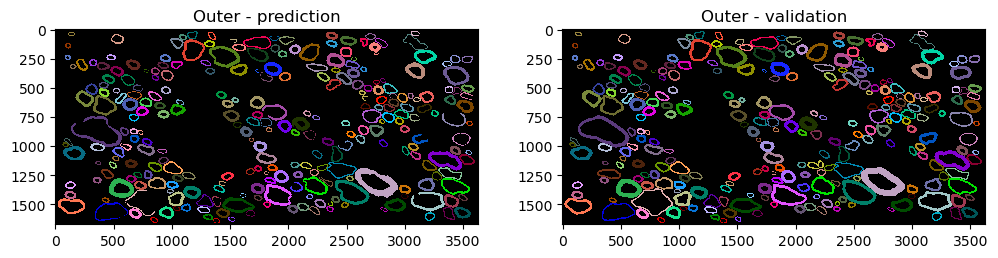

In [193]:
## do the same regression analysis as before
# visually compare outer_labeled and validation data
fig, axs = plt.subplots(ncols=2,figsize=(12,12))
axs[0].imshow(pred_outer_labeled, cmap=glasbey,interpolation='none',vmin=0.1,vmax=pred_outer_labeled.max())
axs[1].imshow(val_outer_labeled, cmap=glasbey,interpolation='none',vmin=0.1,vmax=pred_outer_labeled.max())
axs[0].set_title('Outer - prediction')
axs[1].set_title('Outer - validation')
plt.show()

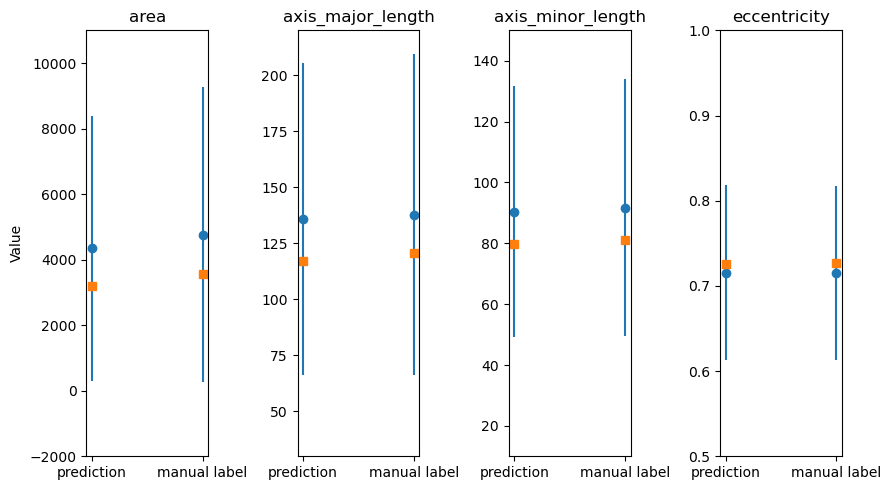

In [194]:
## now that we have the same amount of cells and all cells have the same label in both pictures, we extract measurements for validation
table_outer_pred = regionprops_table(label_image=pred_outer_labeled,
                          properties=('label',
                                      'area',
                                      'centroid',
                                      'axis_major_length',
                                      'axis_minor_length',
                                      'eccentricity',
                                      'extent',
                                      'equivalent_diameter_area',
                                      'orientation',
                                      'slice'))
measurements_outer_pred = pd.DataFrame(table_outer_pred)
#measurements_outer_pred.drop(66,inplace=True)

table_outer_val = regionprops_table(label_image=val_outer_labeled,
                              properties=('label',
                                          'area',
                                          'centroid',
                                          'axis_major_length',
                                          'axis_minor_length',
                                          'eccentricity',
                                          'extent',
                                          'equivalent_diameter_area',
                                          'orientation',
                                          'slice'))
measurements_outer_val = pd.DataFrame(table_outer_val)
#measurements_outer_val.drop(66,inplace=True)

# drop uninteresting columns for now
measurements_outer_val=measurements_outer_val.drop(columns=['label','centroid-0','centroid-1','extent','equivalent_diameter_area','orientation','slice'])
measurements_outer_pred=measurements_outer_pred.drop(columns=['label','centroid-0','centroid-1','extent','equivalent_diameter_area','orientation','slice'])

# calculate mean and std of all columns for both dataframes
stats_outer_pred = pd.concat([measurements_outer_pred.mean(),measurements_outer_pred.median(), measurements_outer_pred.std()], axis=1)
stats_outer_pred.columns = ['mean','median', 'std']
stats_outer_pred['dataset'] = 'prediction'

stats_outer_val = pd.concat([measurements_outer_val.mean(),measurements_outer_val.median(), measurements_outer_val.std()], axis=1)
stats_outer_val.columns = ['mean','median', 'std']
stats_outer_val['dataset'] = 'manual label'

# combine the two datasets
stats = pd.concat([stats_outer_pred, stats_outer_val])

fig, axs = plt.subplots(ncols=measurements_outer_pred.shape[1], figsize=(9, 5))

for i, col in enumerate(measurements_outer_pred.columns):
    ax = axs[i]
    col_stats = stats.loc[stats.index == col, :]
    xticks = np.arange(len(col_stats))
    
    ax.errorbar(xticks, col_stats['mean'], yerr=col_stats['std'], fmt='o', label='Mean')
    ax.errorbar(xticks, col_stats['median'], fmt='s', label='Median')
    ax.set_xticks(xticks)
    ax.set_xticklabels(col_stats['dataset'])
    ax.set_title(col)
    
    if i == 0:
        ax.set_ylabel('Value')
        ax.set_ylim(-2000, 11000)
    if i == 1:
        ax.set_ylim(30, 220)
    if i == 2:
        ax.set_ylim(10, 150)
    if i == 3:
        ax.set_ylim(0.5, 1)

plt.tight_layout()
plt.savefig(save_path + "\outer_lineplot.png", dpi=500)
plt.show()

In [195]:
print('predicted stats:')
print(stats_outer_pred)
print('')
print('validation stats:')
print(stats_outer_val)

predicted stats:
                          mean       median          std     dataset
area               4348.040892  3190.000000  4044.088397  prediction
axis_major_length   135.895615   117.139732    69.424293  prediction
axis_minor_length    90.419283    79.658305    41.143450  prediction
eccentricity          0.715176     0.725372     0.102729  prediction

validation stats:
                          mean       median          std       dataset
area               4763.449814  3562.000000  4499.735547  manual label
axis_major_length   137.847910   120.529166    71.556400  manual label
axis_minor_length    91.691077    81.008655    42.301433  manual label
eccentricity          0.714936     0.727453     0.102110  manual label


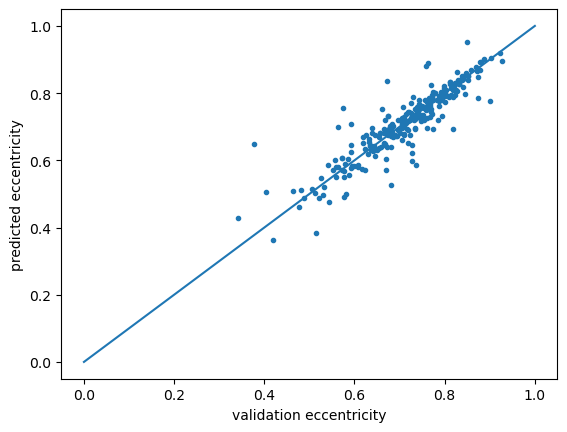

LinregressResult(slope=0.9080009297363123, intercept=0.06601326430459986, rvalue=0.9025288537588797, pvalue=1.0917616636918207e-99, stderr=0.026513876561141153, intercept_stderr=0.019147372800467827)


In [196]:
x = np.arange(0,2)
y = np.arange(0,2)
set_val = (measurements_outer_val['eccentricity'])
set_pred = (measurements_outer_pred['eccentricity'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation eccentricity')
plt.ylabel('predicted eccentricity')
plt.savefig(save_path + "\outer_ecc.png",dpi=500)
plt.show()
print(stats_val_pred)

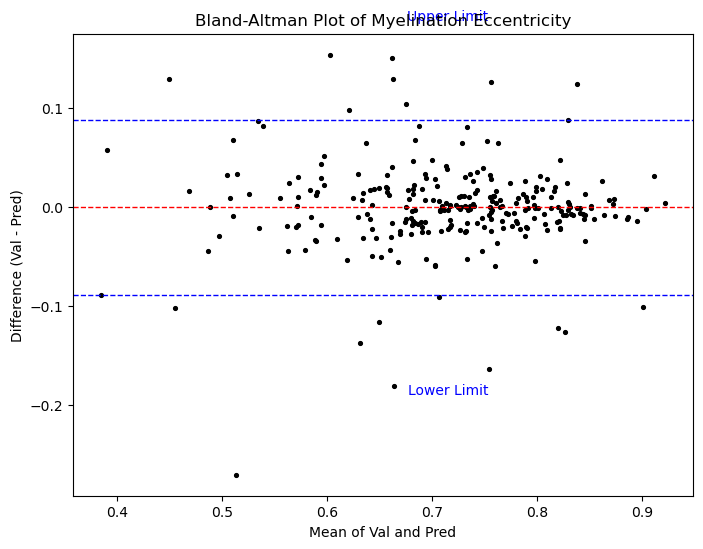

In [197]:
# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Myelination Eccentricity')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\outer_ecc_ba.png",dpi=500)

# Display the plot
plt.show()


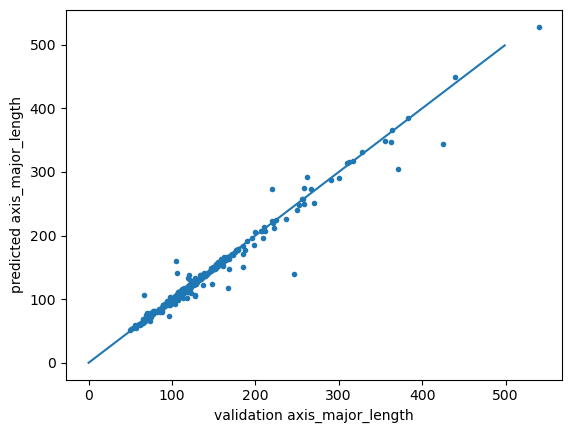

LinregressResult(slope=0.9549086747819444, intercept=4.263450201767142, rvalue=0.9842351059323874, pvalue=6.539817689018776e-203, stderr=0.010501454365314291, intercept_stderr=1.6303767432936807)


In [198]:
x = np.arange(0,500)
y = np.arange(0,500)
set_val = (measurements_outer_val['axis_major_length'])
set_pred = (measurements_outer_pred['axis_major_length'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation axis_major_length')
plt.ylabel('predicted axis_major_length')
plt.savefig(save_path + "\outer_major.png",dpi=500)
plt.show()
print(stats_val_pred)

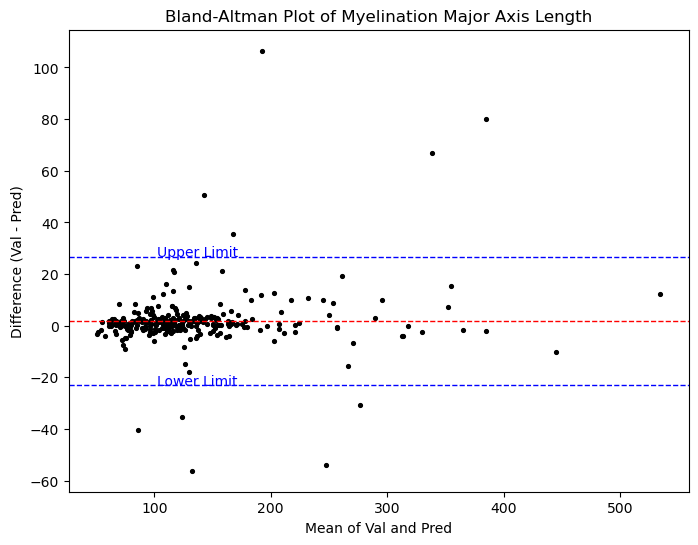

In [199]:
# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Myelination Major Axis Length')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\outer_major_ba.png",dpi=500)

# Display the plot
plt.show()


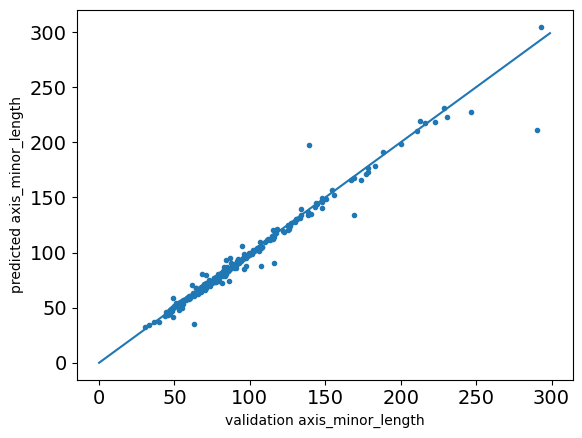

LinregressResult(slope=0.9571541786792948, intercept=2.6567858218078158, rvalue=0.9840933017483523, pvalue=2.1412321095315965e-202, stderr=0.010574529668320362, intercept_stderr=1.0674521639389565)


In [200]:
x = np.arange(0,300)
y = np.arange(0,300)
set_val = (measurements_outer_val['axis_minor_length'])
set_pred = (measurements_outer_pred['axis_minor_length'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

plt.xticks([0, 50, 100, 150, 200, 250, 300])
plt.yticks([0, 50, 100, 150, 200, 250, 300])

plt.tick_params(axis='both', which='major', labelsize=14)  # You can adjust the font size as needed
plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation axis_minor_length')
plt.ylabel('predicted axis_minor_length')
plt.savefig(save_path + "\outer_minor.png",dpi=500)
plt.show()
print(stats_val_pred)

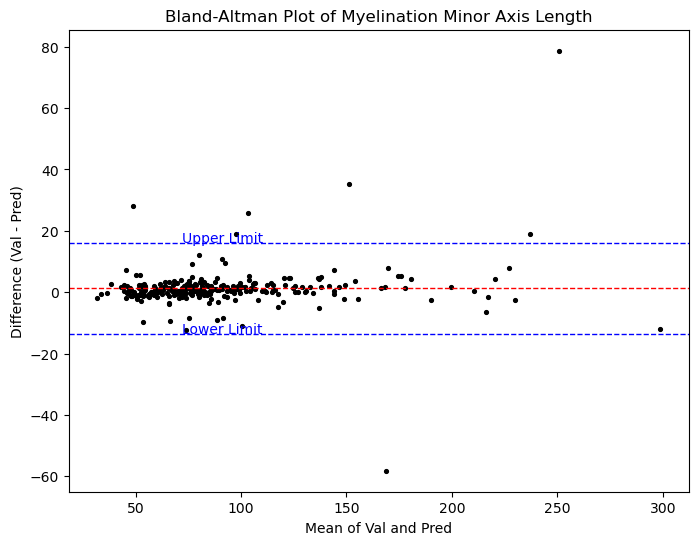

In [201]:
# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Myelination Minor Axis Length')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\outer_minor_ba.png",dpi=500)

# Display the plot
plt.show()


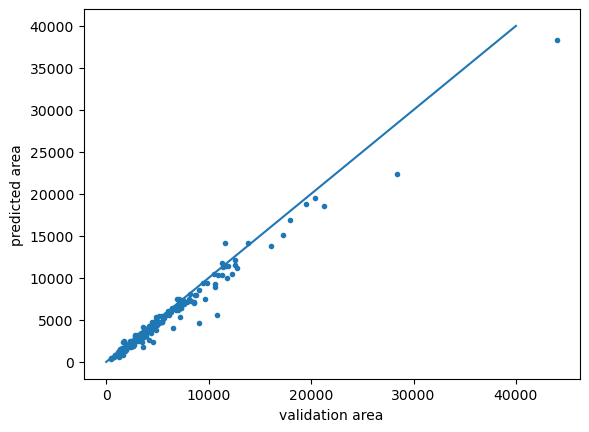

LinregressResult(slope=0.8878998027141497, intercept=118.57474199173066, rvalue=0.987939409865383, pvalue=2.471895281665285e-218, stderr=0.008516553318349818, intercept_stderr=55.75761126233014)


In [202]:
x = np.arange(0,40000)
y = np.arange(0,40000)
set_val = (measurements_outer_val['area'])
set_pred = (measurements_outer_pred['area'])

stats_val_pred = scipy.stats.linregress(set_val,set_pred)

plt.scatter(set_val,set_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation area')
plt.ylabel('predicted area')
plt.savefig(save_path + "\outer_area.png",dpi=500)
plt.show()
print(stats_val_pred)

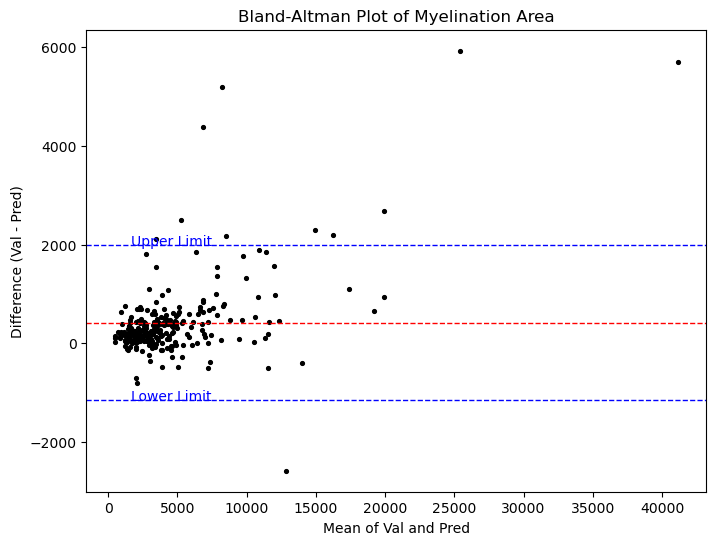

In [203]:
# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(set_val)
set_pred = np.array(set_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of Myelination Area')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\outer_area_ba.png",dpi=500)

# Display the plot
plt.show()


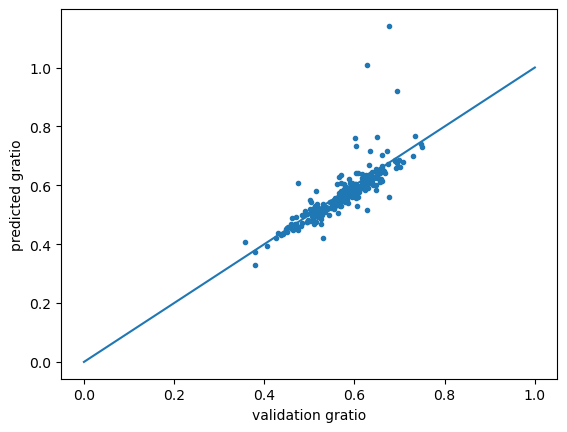

LinregressResult(slope=1.0236106694908251, intercept=-0.01897715315069326, rvalue=0.8119264715371622, pvalue=2.3037789474886546e-64, stderr=0.04503981453076646, intercept_stderr=0.026100635040180235)


In [204]:
# calculate gratio for validation and prediction set, plot them against each other and run linreg
# gratio = inner_minor/outer_minor
x = np.arange(0,2)
y = np.arange(0,2)

gratio_pred = measurements_inner_pred['axis_minor_length']/measurements_outer_pred['axis_minor_length']
gratio_val  = measurements_inner_val['axis_minor_length']/measurements_outer_val['axis_minor_length']

stats_val_pred = scipy.stats.linregress(gratio_val,gratio_pred)

plt.scatter(gratio_val,gratio_pred,marker='.')
plt.plot(x,y)
plt.xlabel('validation gratio')
plt.ylabel('predicted gratio')
plt.savefig(save_path + "\gratio.png",dpi=500)
plt.show()
print(stats_val_pred)

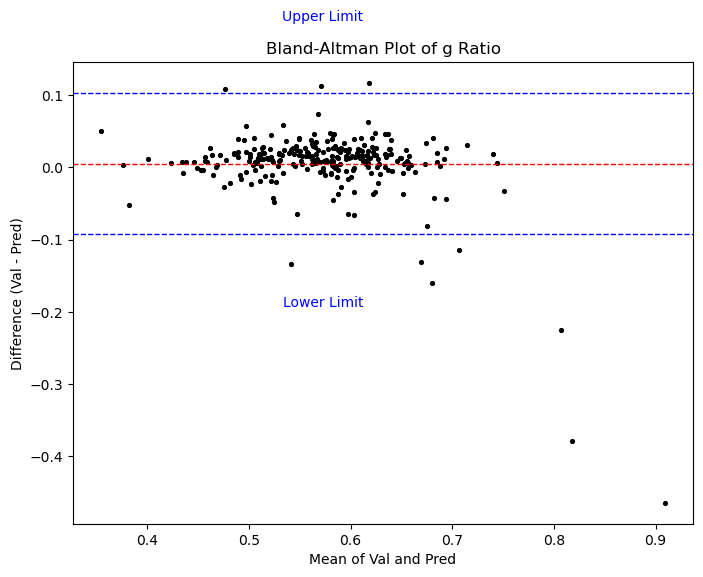

[0.62468527 0.62837359 0.6498307  0.40649908 0.60458804 0.61653892
 0.57958009 0.65953316 0.6600963  0.62340695 0.45058608 0.6769594
 0.52591748 0.6180398  0.61701926 0.65627115 0.58535089 0.46136485
 0.5546569  0.58974067 0.37965941 0.5794677  0.61115739 0.52866626
 0.62502868 0.56858489 0.57606448 0.51653294 0.60507308 0.52926553
 0.59294852 0.50156438 0.51186155 0.50749347 0.66569816 0.56518628
 0.6072912  0.50024741 0.62875719 0.60589182 0.61724383 0.54414841
 0.45005872 0.54002796 0.58013147 0.55752892 0.56368303 0.63102336
 0.5865701  0.45249027 0.56868539 0.5087199  0.60414441 0.74783601
 0.51962161 0.58364986 0.51107547 0.73492022 0.60562783 0.51487119
 0.46272437 0.63047738 0.60781267 0.53382392 0.56798956 0.50434294
 0.62714719 0.47090322 0.6422133  0.69131967 0.61650665 0.56988129
 0.60103236 0.60158542 0.6665485  0.59404    0.46778788 0.63179224
 0.61858574 0.63575865 0.53879063 0.5965245  0.65927518 0.70710944
 0.52314013 0.53013928 0.65472868 0.53006522 0.63838102 0.72982

In [205]:
# Assuming set_val and set_pred are numpy arrays or lists
set_val = np.array(gratio_val)
set_pred = np.array(gratio_pred)

# Calculate the mean and difference
mean = np.mean([set_val, set_pred], axis=0)
diff = set_val - set_pred

# Calculate the limits of agreement (mean difference ± 1.96 * standard deviation of differences)
mean_diff = np.mean(diff)
std_diff = np.std(diff)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

# Plotting the Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean, diff, color='black', s=30, marker='.')
plt.axhline(mean_diff, color='red', linestyle='--', linewidth=1)
plt.axhline(upper_limit, color='blue', linestyle='--', linewidth=1)
plt.axhline(lower_limit, color='blue', linestyle='--', linewidth=1)

# Adding labels and titles
plt.xlabel('Mean of Val and Pred')
plt.ylabel('Difference (Val - Pred)')
plt.title('Bland-Altman Plot of g Ratio')

# Adding text for limits of agreement
plt.text(mean.mean(), upper_limit + 0.1, 'Upper Limit', color='blue', ha='center')
plt.text(mean.mean(), lower_limit - 0.1, 'Lower Limit', color='blue', ha='center')

# Save plot
plt.savefig(save_path + "\gratio_ba.png",dpi=500)

# Display the plot
plt.show()

print(set_val)


In [206]:
# print other statistics
print ("Correctly identified cells (prediction): " + str (len(set_pred)))
print ("False Positives (prediction): " + str (n_false_positive))
print ("False Negatives (prediction): " + str (n_false_negative))
print ("Percentage of cells found: " + str(len(set_pred)/(len(set_pred)+n_false_negative))) # found cells divided by found cells + false negatives
print ("Percentage of cells falsely identified: " + str(n_false_positive/(len(set_pred)+n_false_positive)))
print ("Cells removed because of touching border (prediction): " + str(n_cells_removed_border_pred))
print ("Cells removed because of touching border (validation): " + str(n_cells_removed_border_val))
print ("Cells removed because labeled without inner (prediction): " + str (n_labeled_without_inner))
print ("Cells removed because labeled without outer (prediction): " + str (n_labeled_without_outer))
print ("IoU for fibers: " + str (iou_inner))
print ("IoU for myelin: " + str (iou_outer))
print ("dice coefficient / F1 score for fibers: " + str (dice_inner))
print ("dice coefficient / F1 score for myelin: " + str (dice_outer))

Correctly identified cells (prediction): 269
False Positives (prediction): 10
False Negatives (prediction): 50
Percentage of cells found: 0.8432601880877743
Percentage of cells falsely identified: 0.035842293906810034
Cells removed because of touching border (prediction): 44
Cells removed because of touching border (validation): 8
Cells removed because labeled without inner (prediction): 0
Cells removed because labeled without outer (prediction): 8
IoU for fibers: 0.8974633017136686
IoU for myelin: 0.8226586075759221
dice coefficient / F1 score for fibers: 0.9459611692127449
dice coefficient / F1 score for myelin: 0.9027018051065875


In [207]:
# write everything from above into a file as well
text_to_write = """Correctly identified cells (prediction): {}
False Positives (prediction): {}
False Negatives (prediction): {}
Percentage of cells found: {}
Percentage of cells falsely identified: {}
Cells removed because of touching border (prediction): {}
Cells removed because of touching border (validation): {}
Cells removed because labeled without inner (prediction): {}
Cells removed because labeled without outer (prediction): {}
IoU for fibers: {}
IoU for myelin: {}
dice coefficient / F1 score for fibers: {}
dice coefficient / F1 score for myelin: {}""".format(
    len(set_pred),
    n_false_positive,
    n_false_negative,
    len(set_pred)/(len(set_pred)+n_false_negative),
    n_false_positive/(len(set_pred)+n_false_positive),
    n_cells_removed_border_pred,
    n_cells_removed_border_val,
    n_labeled_without_inner,
    n_labeled_without_outer,
    iou_inner,
    iou_outer,
    dice_inner,
    dice_outer
)

# Write the text to the file
with open(os.getcwd() + r"\5_val_results\results.txt", "w") as file:
    file.write(text_to_write)